In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

# SemTorch
from semtorch import get_segmentation_learner

from pathlib import Path
import random

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
import torch
torch.cuda.set_device(0)

In [3]:
%matplotlib inline
import numpy as np



Function por stablishing the seed for reproducibility


In [4]:
number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
path = Path("dataset/")
path_images = path/"Images"
path_labels = path/"Labels"

test_name = "test"

Obtaining the label associated with an image, in the case of segmentation it is a mask

In [6]:
get_y_fn = lambda x: Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))



Aux function for splitting between training and testing


In [7]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

Loading the codes of the different classes. All the datasets have the same codes.

In [8]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [9]:
def msa(input, target):
    target = target.squeeze(1)
    mask = target != -1
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def background(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def leaves(input, target):
    target = target.squeeze(1)
    mask = target != 1
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def wood(input, target):
    target = target.squeeze(1)
    mask = target != 2
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def pole(input, target):
    target = target.squeeze(1)
    mask = target != 3
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def grape(input, target):
    target = target.squeeze(1)
    mask = target != 4
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

Early Stopping parameters

In [10]:
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=3

In [11]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [12]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [13]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 4
        mask[mask==255]=4
        mask[mask==150]=1
        mask[mask==76]=3
        mask[mask==74]=3
        mask[mask==29]=2
        mask[mask==25]=2
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [14]:
path_manual_img = path_images/'train'
path_manual_lbl = path_labels/'train'

dataset/Images/train/color_159.jpg


<AxesSubplot:>

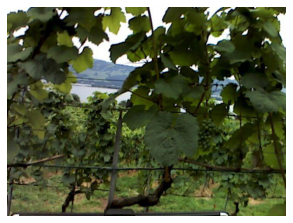

In [15]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

# open and show image
img_f = fnames_manual[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [16]:
print(get_y_fn(img_f))

dataset/Labels/train/gt_159.png


<AxesSubplot:>

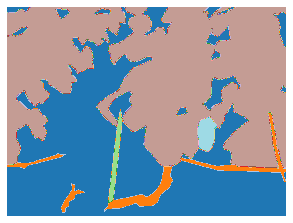

In [17]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [18]:
np.unique(np.array(mask))

array([  0,  29,  76, 150, 255], dtype=uint8)

In [19]:
bs = 4

In [20]:
codes

array(['Background', 'Leaves', 'Wood', 'Pole', 'Grape'], dtype='<U10')

In [21]:
def my_get_items(folders,path):
    return (get_image_files(path))

In [22]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train','test']),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((480,640)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
#manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
#dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [23]:
#x,mask=dls.one_batch()

# Deeplab

In [24]:
import segmentation_models_pytorch as smp


In [25]:
model = smp.MAnet(
    encoder_name="timm-resnest50d",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=5,                      # model output channels (number of classes in your dataset)
)

In [26]:
learn = Learner(dls,model,metrics=[background,leaves,pole,grape,wood,msa]).to_fp16()

Recorder

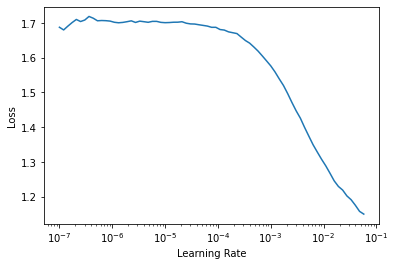

In [27]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,background,leaves,pole,grape,wood,msa,time
0,1.615435,2.054137,0.859760,0.077538,0.463461,0.461543,0.464695,0.457140,00:12
1,1.427208,1.554660,0.775448,0.497470,0.661476,0.659080,0.665383,0.653220,00:12
2,1.155384,0.665384,0.743869,0.799828,0.820833,0.819753,0.825603,0.810203,00:13
3,0.921104,0.737662,0.754744,0.686137,0.759633,0.759325,0.764743,0.750476,00:13
4,0.756811,0.550131,0.807459,0.753215,0.825916,0.824213,0.830090,0.814606,00:12
5,0.648384,0.689385,0.891973,0.562031,0.756803,0.756348,0.761734,0.747544,00:12
6,0.565195,0.472503,0.833104,0.773109,0.839356,0.842852,0.848856,0.833018,00:12
7,0.511130,0.458499,0.817750,0.786204,0.837292,0.841753,0.847727,0.831921,00:12
8,0.468686,0.499032,0.844953,0.748049,0.834358,0.836141,0.842089,0.826379,00:13
9,0.427082,0.528165,0.874005,0.692891,0.812277,0.816408,0.822210,0.806857,00:12


Better model found at epoch 0 with valid_loss value: 2.0541365146636963.


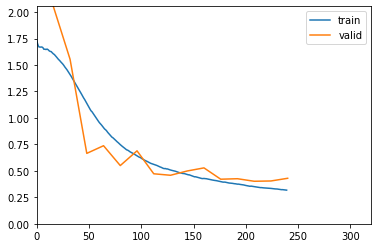

Better model found at epoch 1 with valid_loss value: 1.5546600818634033.
Better model found at epoch 2 with valid_loss value: 0.6653836369514465.
Better model found at epoch 4 with valid_loss value: 0.5501308441162109.
Better model found at epoch 6 with valid_loss value: 0.4725029170513153.
Better model found at epoch 7 with valid_loss value: 0.4584992229938507.
Better model found at epoch 10 with valid_loss value: 0.4212203025817871.
Better model found at epoch 12 with valid_loss value: 0.40179285407066345.
No improvement since epoch 12: early stopping


In [28]:
fname="deeplab-before-unfreeze"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [29]:
learn.load("deeplab-before-unfreeze")
learn.unfreeze()
#learn.lr_find() # find learning rate
#learn.recorder # plot learning rate graph

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,background,leaves,pole,grape,wood,msa,time
0,0.282230,0.411027,0.849264,0.792587,0.848774,0.845524,0.859224,0.843186,00:13
1,0.276622,0.435647,0.867216,0.759672,0.839524,0.835593,0.849484,0.833628,00:13
2,0.280669,0.415819,0.854977,0.783573,0.846633,0.843286,0.856975,0.840978,00:13
3,0.283088,0.417300,0.854317,0.782620,0.845308,0.842474,0.855969,0.839992,00:13


Better model found at epoch 0 with valid_loss value: 0.4110274612903595.


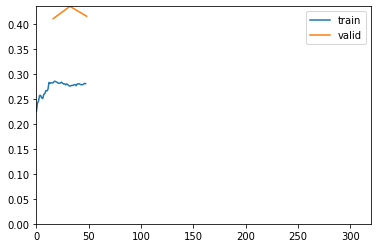

No improvement since epoch 0: early stopping


In [31]:
fname="Manet-Resnest"


callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-7,1e-7),cbs=callbacksFitAfterUnfreeze)

In [32]:
learn.validate()

(#7) [0.4110274612903595,0.8492639660835266,0.7925866842269897,0.8487737774848938,0.845524251461029,0.8592244982719421,0.84318608045578]

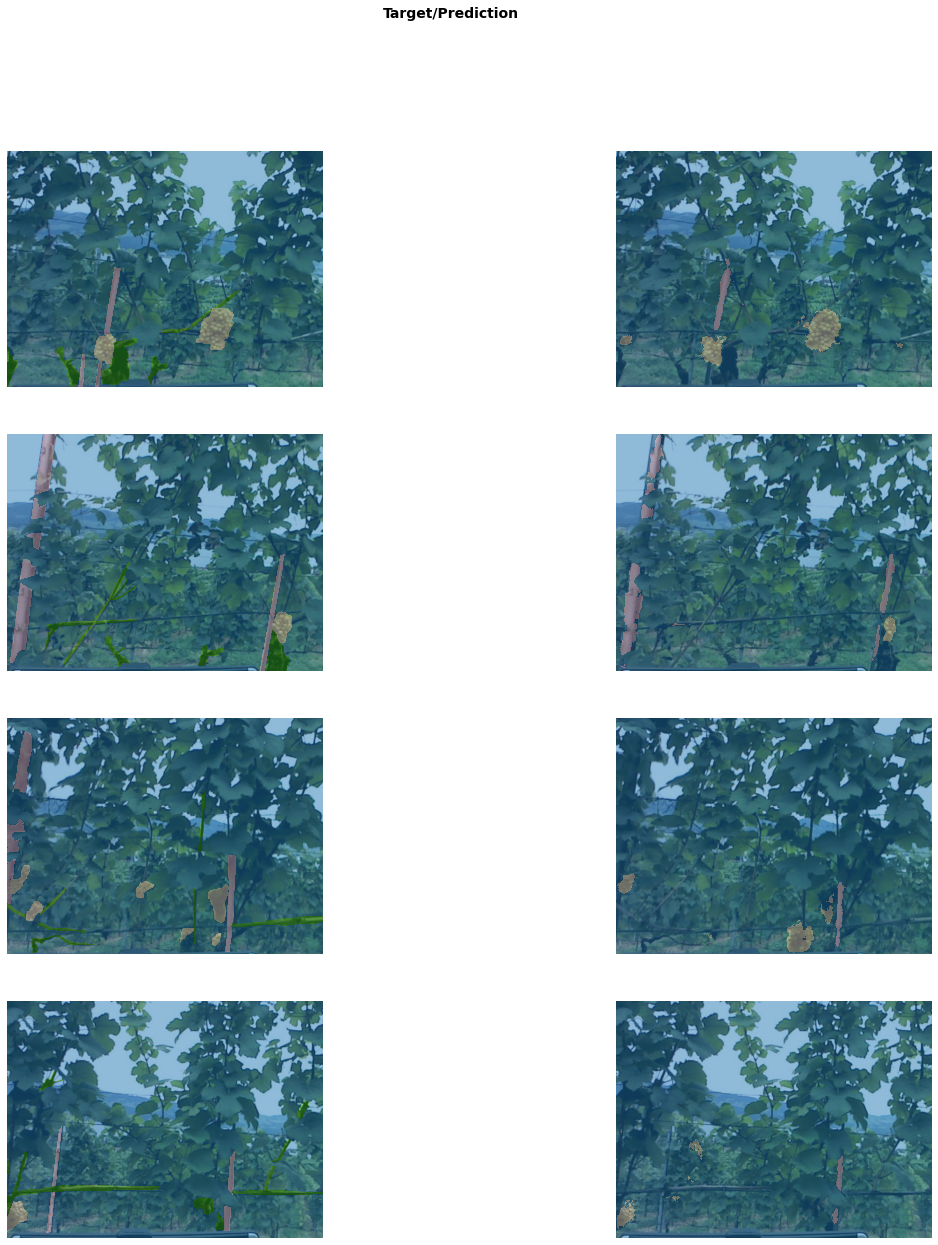

In [29]:
learn.show_results(figsize=(20,20))

In [28]:
learn.load("Manet-Resnest")

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [30]:
aux=learn.model
aux=aux.cpu()


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# HRNet



In [36]:
import torchvision.transforms as transforms
def transform_image(image):
    my_transforms = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image_aux = image
    return my_transforms(image_aux).unsqueeze(0).to(device)

In [51]:
image = Image.open('dataset/Images/trainSemi/color00026.jpg')

In [52]:
image = transforms.Resize((480,640))(image)
tensor = transform_image(image=image)

In [53]:
model.to(device)
with torch.no_grad():
    outputs = model(tensor)

outputs = torch.argmax(outputs,1)

In [54]:
mask = np.array(outputs.cpu())

In [55]:
mask[mask==4]=255
mask[mask==1]=150
mask[mask==3]=76
mask[mask==2]=29

In [56]:
mask=np.reshape(mask,(480,640))

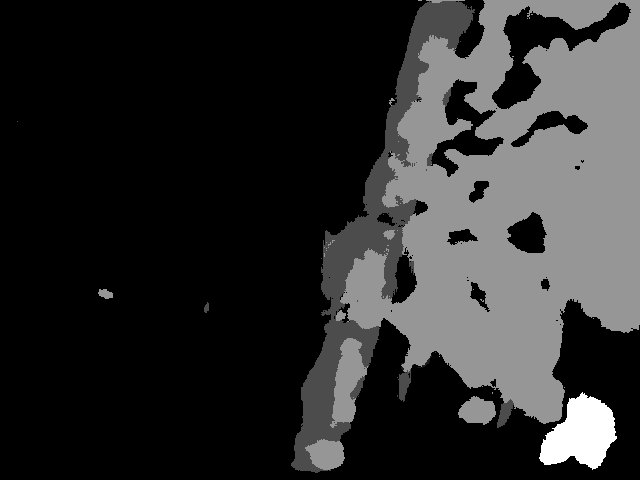

In [57]:
maskShow = Image.fromarray(mask.astype('uint8'))
maskShow

In [60]:
maskrgb = maskShow.convert('RGB')
maskrgb = np.array(maskrgb)
maskrgb[(maskrgb==[150,150,150]).all(axis=2)]=[0,255,0]
maskrgb[(maskrgb==[76,76,76]).all(axis=2)]=[255,0,0]
maskrgb[(maskrgb==[29,29,29]).all(axis=2)]=[0,0,255]

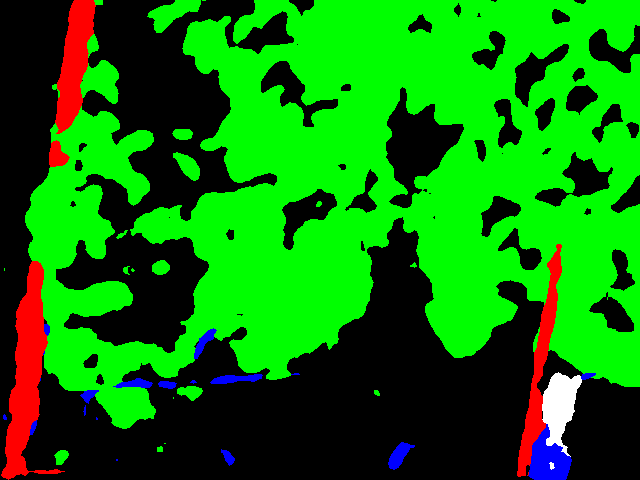

In [61]:
maskRGBShow = Image.fromarray(maskrgb.astype('uint8'))
maskRGBShow

In [43]:
maskRGBShow.save('deeplab_pred_155.jpg')